In [1]:
import numpy as np
import scipy.stats as sps
from IPython.core.debugger import Tracer
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.sans-serif'] = 'Arial'
from matplotlib.ticker import MultipleLocator
import seaborn as sns
# %gui qt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(style='ticks', font='sans-serif')
sns.set_context('notebook', font_scale=1)
from matplotlib.ticker import FormatStrFormatter
from matplotlib.collections import LineCollection


import matplotlib.gridspec as gridspec

# import plotly
# import plotly.graph_objs as go
# import plotly.offline as plo
# plotly.offline.init_notebook_mode(connected=True)

import scipy.interpolate as spi

import ipywidgets as widgets

import pickle

import signatures as sg

import joblib as jl


def caption_letter(axis, letter, prop_above=0.1, prop_left=0.1):
    yl = axis.get_ylim()
    xl = axis.get_xlim()
    axis.text(xl[0]-prop_left*np.diff(xl), yl[1]+prop_above*np.diff(yl), letter, horizontalalignment='right', fontsize=18, fontweight='bold')

cat1_color = [.8047, .3125, .3398]
cat2_color = [.4766, .7344, .793]



## Section 1. Confidence divergence

In [224]:
slopes_u, slopes_g = pickle.load(open('slopes.p'))

In [225]:
SDs_u = np.linspace(0, 1.8, 32)
SDs_g = np.linspace(0, 3, 32)
cat_params_u = np.linspace(0, 2.5, 32)
cat_params_g = np.linspace(0.3, 2, 32)

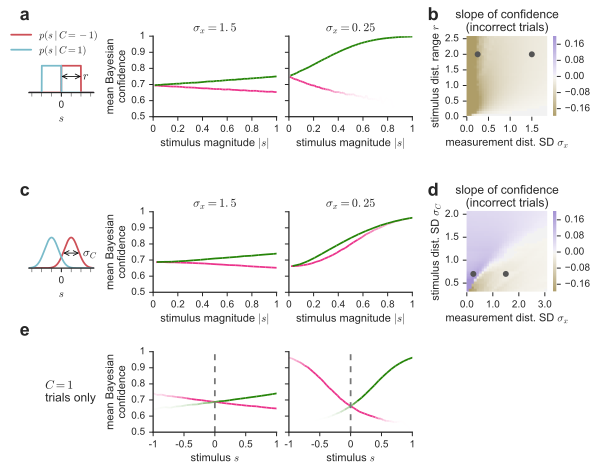

In [234]:
reload(sg)
mpl.rcParams['xtick.major.pad']='4'
mpl.rcParams['ytick.major.pad']='4'
mpl.rcParams['xtick.major.size']='4'
mpl.rcParams['ytick.major.size']='4'
mpl.rcParams['xtick.minor.size']='4'
mpl.rcParams['ytick.minor.size']='4'
mpl.rcParams['axes.labelpad']='4'

figsize = (7.5,5.5) # W, H
group_h_margin = .24
h_margin = .15
row_height = (1-h_margin-group_h_margin)/3

cat_plot_w = .12
cat_plot_w_margin = .11
cat_plot_rel_h = .4
cat_plot_h = cat_plot_rel_h*row_height

heatmap_w = .2
heatmap_w_margin = .09

heatmap_prop_left = .35

wspace=.1

caption_letter_prop_above = .2

# gs1 = grdispec.GridSpec()
# cats1 = plt.subplots(gridspec_kw={'left': 0, 'right': cat_plot_w, 'top': 1-(row_height-cat_plot_h)/2, 'bottom': 1-(row_height-cat_plot_h)/2-cat_plot_h})

gs1 = gridspec.GridSpec(2,1)
gs1.update(left=0, right=cat_plot_w, top=1-(row_height-cat_plot_h)/2, bottom=1-row_height-group_h_margin-cat_plot_h-(row_height-cat_plot_h)/2, hspace=(group_h_margin+row_height-cat_plot_h)/cat_plot_h)

cats1 = plt.subplot(gs1[0])
cats2 = plt.subplot(gs1[1])

gs2 = gridspec.GridSpec(1, 2)
gs2.update(left=cat_plot_w+cat_plot_w_margin, right=1-heatmap_w-heatmap_w_margin, top=1, bottom=1-row_height, wspace=wspace)

u1 = plt.subplot(gs2[0])
u2 = plt.subplot(gs2[1])


gs3 = gridspec.GridSpec(2, 2)
gs3.update(left=cat_plot_w + cat_plot_w_margin, right=1-heatmap_w-heatmap_w_margin, top=1-row_height-group_h_margin, bottom=0, hspace=h_margin/row_height, wspace=wspace)
# fig, cats2 = plt.subplots(gridspec_kw={'left': 0, 'right': cat_plot_w, 'top': 1-row_height-group_h_margin-(row_height-cat_plot_h)/2, 'bottom': 1-row_height-group_h_margin-(row_height-cat_plot_h)/2-cat_plot_h})


g1 = plt.subplot(gs3[0])
g2 = plt.subplot(gs3[1])
g3 = plt.subplot(gs3[2])
g4 = plt.subplot(gs3[3])

gs4 = gridspec.GridSpec(2,1)
gs4.update(left=1-heatmap_w, right=1, top=1, bottom=row_height+h_margin, hspace=group_h_margin/row_height)
uheat = plt.subplot(gs4[0])
gheat = plt.subplot(gs4[1])




# HANDLES ###################
# cats1     u1   u2     uheat
# 
# cats2     g1   g2     gheat
#           g3   g4


unif_range = 2
xl = [0,1]
yl = [.5,1]
distxl=[-3.3,3.3]
lo_SD = .25
hi_SD = 1.5
nBins = 80
nTrials = int(5e6) # 2e6
s = np.linspace(distxl[0],distxl[1],500)
markersize=12 # dots on heatmap
#### ROW 1 ##########

stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='uniform', unif_range=unif_range)
cats1.plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='$p(s \mid C = -1)$')
cats1.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='$p(s \mid C = 1)$')
cats1.set_xlim(distxl)
cats1.set_ylim([0,.6])
cats1.set_yticks([])
# ax[0][0].legend()
# apos = ax[0][0].get_position()
# ax[0][0].set_position(np.array(apos.bounds)+[lshift,hshift,lshift_mult,-2*hshift])
cats1.xaxis.set_major_locator(MultipleLocator(20))
cats1.xaxis.set_minor_locator(MultipleLocator(1))
# cats1.tick_params('both', length=4.5, which='minor')
cats1.set_xticks([0])
cats1.set_xticklabels([0])
cats1.set_xlabel('$s$')
l = cats1.legend(bbox_to_anchor=(1.2, 2.2))
l.axes.set_position(l.axes.get_position())

cats1.annotate(s='', xy=(-.2,.3), xytext=(2.2,.3), arrowprops=dict(arrowstyle='<->', lw=0.8))
cats1.text(2.2, 0.3, '$r$', verticalalignment='center')


data = sg.experiment(type='uniform', nTrials=nTrials, unif_overlap=0, meas_SD=hi_SD, unif_range=unif_range)
sg.plot_divergence_panel(u1, data, nBins=nBins)
u1.set_ylim(yl)
u1.set_xlim(xl)
# ax[0][1].legend(loc='upper left')
u1.set_title('$\sigma_x={}$'.format(hi_SD))
caption_letter(u1, 'a', prop_left=1, prop_above=caption_letter_prop_above)

data = sg.experiment(type='uniform', nTrials=nTrials, unif_overlap=0, meas_SD=lo_SD, unif_range=unif_range)
sg.plot_divergence_panel(u2, data, ylabel=False, nBins=nBins)
u2.set_xlim(xl)
u2.set_ylim(yl)
u2.set_title('$\sigma_x={}$'.format(lo_SD))

xxx= sg.make_heatmap(slopes_u.T, SDs_u, cat_params_u, uheat, xticks=np.arange(0,1.6,.5), yticks=np.arange(0,2.6,.5))
# apos = ax[0][3].get_position()
# ax[0][3].set_position(np.array(apos.bounds)+[.03,0,0,0])
uheat.set_ylabel('stimulus dist. range $r$')
uheat.set_xlabel('measurement dist. SD $\sigma_x$')
uheat.set_title('slope of confidence\n(incorrect trials)', size=12)
uheat.plot(np.interp([hi_SD, lo_SD], SDs_u, range(len(SDs_u))), len(cat_params_u)-np.interp([2,2], cat_params_u, range(len(cat_params_u))), '.', color='#555555', markersize=markersize)
caption_letter(uheat, 'b', prop_left=heatmap_prop_left, prop_above=caption_letter_prop_above)

stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='gaussian', unif_range=unif_range, norm_mean=1, norm_SD=.7)
cats2.plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='cat. 1')
cats2.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='cat. 2')
cats2.set_xlim(distxl)
cats2.set_ylim([0,.6])
cats2.set_yticks([])
cats2.set_xticklabels('')
cats2.xaxis.set_major_locator(MultipleLocator(20))
cats2.xaxis.set_minor_locator(MultipleLocator(1))
# cats2.tick_params('both', length=4.5, which='minor')
cats2.set_xticks([0])
cats2.set_xticklabels([0])
cats2.set_xlabel('$s$')

cats2.annotate(s='', xy=(0,.28), xytext=(2,.28), arrowprops=dict(arrowstyle='<->', lw=0.8))
cats2.text(2.2, 0.28, '$\sigma_C$', verticalalignment='center')
# cats2.annotate(s='', xy=(1,.55), xytext=(1,.82), arrowprops=dict(arrowstyle='->', lw=0.8))
# cats2.text(1, .87, '$\mu_C$', horizontalalignment='center')

data = sg.experiment(type='gaussian', nTrials=nTrials, norm_mean=1, norm_SD=.7, meas_SD=hi_SD)
sg.plot_divergence_panel(g1, data, nBins=nBins)
g1.set_xlim(xl)
g1.set_ylim(yl)
g1.set_title('$\sigma_x={}$'.format(hi_SD))
caption_letter(g1, 'c', prop_left=1, prop_above=caption_letter_prop_above)

sg.plot_divergence_panel(g3, data, absolute=False, cat=1, nBins=nBins)
g3.set_xlim([-xl[1], xl[1]])
g3.set_ylim(yl)
g3.set_xlabel('stimulus $s$')
g3.axvline(0, color='#777777', linestyle='--')
caption_letter(g3, 'e', prop_left=1, prop_above=caption_letter_prop_above)

g3.text(-2.75, 0.69, '$C=1$\ntrials only')

data = sg.experiment(type='gaussian', nTrials=nTrials, norm_mean=1, norm_SD=.7, meas_SD=lo_SD)
sg.plot_divergence_panel(g2, data, ylabel=False, nBins=nBins)
g2.set_xlim(xl)
g2.set_ylim(yl)
g2.set_title('$\sigma_x={}$'.format(lo_SD))

sg.make_heatmap(slopes_g.T, SDs_g, cat_params_g, gheat, yticks=np.arange(.5,2.1,.5), xticks=np.arange(0,3.1,1))
gheat.set_ylabel('stimulus dist. SD $\sigma_C$')
gheat.set_xlabel('measurement dist. SD $\sigma_x$')
gheat.set_title('slope of confidence\n(incorrect trials)', size=12)
gheat.plot(np.interp([hi_SD, lo_SD], SDs_g, range(len(SDs_g))), len(cat_params_g)-np.interp([.7,.7], cat_params_g, range(len(cat_params_g))), '.', color='#555555', markersize=markersize)
caption_letter(gheat, 'd', prop_left=heatmap_prop_left, prop_above=caption_letter_prop_above)

sg.plot_divergence_panel(g4, data, ylabel=False, absolute=False, cat=1, nBins=nBins)
g4.set_xlim([-xl[1], xl[1]])
g4.set_ylim(yl)
g4.set_xlabel('stimulus $s$')
g4.axvline(0, color='#777777', linestyle='--')


sns.despine(ax=cats1, left=True)
sns.despine(ax=cats2, left=True)


fig = plt.gcf()
fig.set_size_inches(figsize)
# fig.tight_layout()
fig.savefig('/Users/will/Google Drive/Will - Confidence/Manuscripts/Signatures/sigs_figs/divergence_tmp.pdf', bbox_inches='tight')

In [ ]:
# recompute slopes
slopes_u = sg.incorrect_slopes(SDs=SDs_u, cat_params=cat_params_u)
slopes_g = sg.incorrect_slopes(SDs=SDs_g, cat_params=cat_params_g, type='gaussian')

## Section 2. Mean confidence at neutral evidence

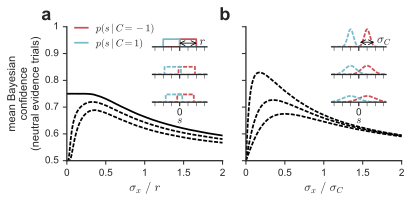

In [313]:
nSigs = 200 # 200
nTrials = 1e6 # 1e6

sigratio = np.linspace(np.finfo(float).eps,2,nSigs)
unif_range = 2
SD = sigratio*unif_range


unif_overlaps = [0, .15, .3]
unif_linestyles = ['-', '--', '--']
dashstyle = [4,1.5]
sig_Cs = [0.35, 0.7, 1]
norm_mean = [1,1,1]

prop_left = .1
prop_above = .05


fig, axes = plt.subplots(1, 2, sharey='row', figsize=(6,2.4))
plt.subplots_adjust(wspace=.15, hspace=.5)

out = np.zeros(len(SD))
for j, overlap in enumerate(unif_overlaps):
    for i, meas_SD in enumerate(SD):
        out[i] = sg.meanconf_sim(type='uniform', meas_SD=meas_SD, unif_overlap=overlap, unif_range=unif_range, nTrials=int(nTrials))
    l, = axes[0].plot(sigratio, out, color='k')
    if unif_linestyles[j] != '-':
        l.set_dashes(dashstyle)


axes[0].set_xlabel('$\sigma_x\ /\ r$',fontsize=12)
axes[0].set_ylim([.5,1])
axes[0].set_xlim([0,2])
axes[0].set_ylabel('mean Bayesian\nconfidence\n(neutral evidence trials)')
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
caption_letter(axes[0], 'a', prop_left=prop_left, prop_above=prop_above)
apos = axes[0].get_position()

x = [apos.x0, apos.x1]
y = [apos.y0, apos.y1]
sns.despine(ax=axes[0])

#### INSETS ##########
LWYHM = [.55, .35, .85, .15, 0.16] # L point, width, Y point, height, margin
ylim = [0,1.3]
s = np.linspace(-4,4,500)
for j, overlap in enumerate(unif_overlaps):
    ax = plt.axes([float(x[0]+np.diff(x)*LWYHM[0]), float(y[0]+np.diff(y)*LWYHM[2])-LWYHM[4]*j, float(np.diff(x)*LWYHM[1]), float(np.diff(y)*LWYHM[3])])
    stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='uniform', unif_range=unif_range, unif_overlap=overlap)
    l,=ax.plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='$p(s \mid C = -1)$')
    if unif_linestyles[j] != '-':
        l.set_dashes(dashstyle)
    l,=ax.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='$p(s \mid C = 1)$')
    if unif_linestyles[j] != '-':
        l.set_dashes(dashstyle)
    
    ax.set_yticks([])
    ax.set_xticks(np.linspace(-3,3,7))
    ax.set_xlim([-3.3,3.3])
    ax.set_xticklabels([])
    ax.set_ylim(ylim)

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks([0])
    
    if j==0:
        ax.annotate(s='', xy=(-.3,.24), xytext=(2.3,.24), arrowprops=dict(arrowstyle='<->', lw=0.8))
        ax.text(2.4, 0.33, '$r$', verticalalignment='center')
        
        l = ax.legend(bbox_to_anchor=(.2, 1.6), handlelength=1.3)
        l.axes.set_position(l.axes.get_position())

        

    elif j==2:
        ax.set_xticklabels([0])
        ax.set_xlabel('$s$', labelpad=-2)
        ax.tick_params(axis='both', which='major', pad=2)

    
    sns.despine(ax=ax, left=True)
    
    
for j, sig_C in enumerate(sig_Cs):
    for i, meas_SD in enumerate(SD):
        out[i] = sg.meanconf_sim(type='gaussian', meas_SD=meas_SD, norm_mean=norm_mean[j], norm_SD=sig_C, nTrials=int(nTrials))
    l,=axes[1].plot(sigratio, out, '--', color='k')
    l.set_dashes(dashstyle)


axes[1].set_xlabel('$\sigma_x\ /\ \sigma_C$',fontsize=12)
axes[1].set_ylim([.5,1])
axes[1].set_xlim([0,2])
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
caption_letter(axes[1], 'b', prop_left=prop_left, prop_above=prop_above)
apos = axes[1].get_position()

x = [apos.x0, apos.x1]
y = [apos.y0, apos.y1]
sns.despine(ax=axes[1])

#### INSETS ##########
s = np.linspace(-4,4,500)
for j, sig_C in enumerate(sig_Cs):
    ax = plt.axes([float(x[0]+np.diff(x)*LWYHM[0]), float(y[0]+np.diff(y)*LWYHM[2])-LWYHM[4]*j, float(np.diff(x)*LWYHM[1]), float(np.diff(y)*LWYHM[3])])
    stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='gaussian', norm_mean=norm_mean[j], norm_SD=sig_C)
    l,=ax.plot(s, stimdist_1.pdf(s), '-', color=cat1_color)
    l.set_dashes(dashstyle)
    l,=ax.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color)
    l.set_dashes(dashstyle)

    ax.set_yticks([])
    ax.set_xticks(np.linspace(-3,3,7))
    ax.set_xlim([-3.3,3.3])
    ax.set_ylim(ylim)
    ax.set_xticklabels([])

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks([0])
    
    if j==0:
        ax.annotate(s='', xy=(-.1,.3), xytext=(2.1,.3), arrowprops=dict(arrowstyle='<->', lw=0.8))
        ax.text(2.2, 0.46, '$\sigma_C$', verticalalignment='center')

    elif j==2:
        ax.set_xticklabels([0])
        ax.set_xlabel('$s$', labelpad=-2)
        ax.tick_params(axis='both', which='major', pad=2)
    
    sns.despine(ax=ax, left=True)

fig.savefig('/Users/will/Google Drive/Will - Confidence/Manuscripts/Signatures/sigs_figs/midrange.pdf', bbox_inches='tight')

## Section 3. Accuracy as function of confidence and evidence

In [ ]:
data = sg.experiment(type='gaussian', nTrials=int(1e5), meas_SD=.5, norm_mean=0.5, norm_SD=0.3)

(0, 0.9)

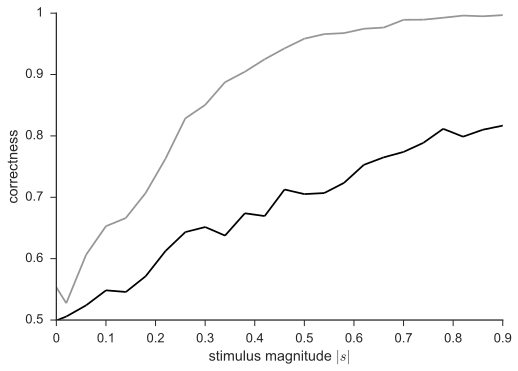

In [154]:
fig, ax = plt.subplots()
sg.plot_divergence_panel(ax, data, conf_threshold=.8, nBins=50, ylabel=True, fade_below_prop=.1, Bayes=True, cat=None, absolute=False)
plt.ylim([.5, 1])
plt.xlim([0, .9])

## Section 4. Alternative divergence signature

In [16]:
nTrials = 5e4  # 5e5
nSigmas = 8  # 16
SDs = [1.5, .25]
# cat_type = 'uniform'
cat_params_u = np.linspace(0.00001,2.5,nSigmas)
cat_params_g = np.linspace(2,0,nSigmas)

# if cat_type == 'uniform':
#     cat_params_u = np.linspace(0.00001,2.5,nSigmas)
#     data = [sg.experiment(type='uniform', nTrials=int(nTrials), meas_SD=meas_SD, unif_range=x) for x in cat_params]
# else:
#     cat_params = np.linspace(2,.0001,nSigmas)
#     data = [sg.experiment(type='gaussian', nTrials=int(nTrials), meas_SD=meas_SD, norm_mean=1, norm_SD=x) for x in cat_params]

# for d in data:
#     d['conf'] = abs(d['x'])

data_u = [[sg.experiment(type='uniform', nTrials=int(nTrials), meas_SD=meas_SD, unif_range=x) for x in cat_params_u] for meas_SD in SDs]
data_g = [[sg.experiment(type='gaussian', nTrials=int(nTrials), meas_SD=meas_SD, norm_mean=1, norm_SD=x) for x in cat_params_g] for meas_SD in SDs]

correct_conf_u = [[np.mean(j['conf'][j['correctness']]) for j in i] for i in data_u]
incorrect_conf_u = [[np.mean(j['conf'][~j['correctness']]) for j in i] for i in data_u]

correct_conf_g = [[np.mean(j['conf'][j['correctness']]) for j in i] for i in data_g]
incorrect_conf_g = [[np.mean(j['conf'][~j['correctness']]) for j in i] for i in data_g]

accuracy_u = [[np.mean(j['correctness']) for j in i] for i in data_u]
accuracy_g = [[np.mean(j['correctness']) for j in i] for i in data_g]

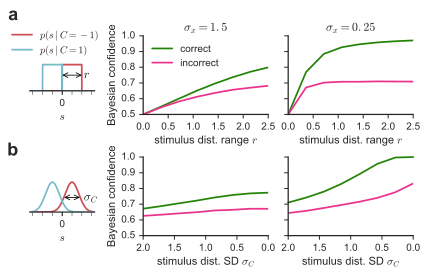

In [18]:
colors=np.array([[235,51,139], [37,132,8]])/255.0 # red, green

mpl.rcParams['xtick.major.pad']='4'
mpl.rcParams['ytick.major.pad']='4'
mpl.rcParams['xtick.major.size']='4'
mpl.rcParams['ytick.major.size']='4'
mpl.rcParams['xtick.minor.size']='4'
mpl.rcParams['ytick.minor.size']='4'
mpl.rcParams['axes.labelpad']='4'

figsize = (7.5,4.55) # W, H
group_h_margin = .13
h_margin = .15
row_height = (1-h_margin-group_h_margin)/3

cat_plot_w = .12
cat_plot_w_margin = .09
cat_plot_rel_h = .4
cat_plot_h = cat_plot_rel_h*row_height

heatmap_w = .2
heatmap_w_margin = .09

heatmap_prop_left = .35

wspace=.16

caption_letter_prop_above = .2

gs1 = gridspec.GridSpec(2,1)
gs1.update(left=0, right=cat_plot_w, top=1-(row_height-cat_plot_h)/2, bottom=1-row_height-group_h_margin-cat_plot_h-(row_height-cat_plot_h)/2, hspace=(group_h_margin+row_height-cat_plot_h)/cat_plot_h)

cats1 = plt.subplot(gs1[0])
cats2 = plt.subplot(gs1[1])

gs2 = gridspec.GridSpec(1, 2)
gs2.update(left=cat_plot_w+cat_plot_w_margin, right=1-heatmap_w-heatmap_w_margin, top=1, bottom=1-row_height, wspace=wspace)

u1 = plt.subplot(gs2[0])
u2 = plt.subplot(gs2[1])


gs3 = gridspec.GridSpec(2, 2)
gs3.update(left=cat_plot_w + cat_plot_w_margin, right=1-heatmap_w-heatmap_w_margin, top=1-row_height-group_h_margin, bottom=0, hspace=h_margin/row_height, wspace=wspace)


g1 = plt.subplot(gs3[0])
g2 = plt.subplot(gs3[1])

gs4 = gridspec.GridSpec(2,1)
gs4.update(left=1-heatmap_w, right=1, top=1, bottom=row_height+h_margin, hspace=group_h_margin/row_height)




# HANDLES ###################
# cats1     u1   u2
# cats2     g1   g2


unif_range = 2
xl = [0,1]
yl = [.5,1]
distxl=[-3.3,3.3]
lo_SD = .25
hi_SD = 1.5
nBins = 80
nTrials = int(1e4) # 2e6
s = np.linspace(distxl[0],distxl[1],500)
markersize=12 # dots on heatmap
#### ROW 1 ##########

stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='uniform', unif_range=unif_range)
cats1.plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='$p(s \mid C = -1)$')
cats1.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='$p(s \mid C = 1)$')
cats1.set_xlim(distxl)
cats1.set_ylim([0,.6])
cats1.set_yticks([])
cats1.xaxis.set_major_locator(MultipleLocator(20))
cats1.xaxis.set_minor_locator(MultipleLocator(1))
cats1.set_xticks([0])
cats1.set_xticklabels([0])
cats1.set_xlabel('$s$')
l = cats1.legend(bbox_to_anchor=(1.2, 2.2))
l.axes.set_position(l.axes.get_position())

cats1.annotate(s='', xy=(-.2,.3), xytext=(2.2,.3), arrowprops=dict(arrowstyle='<->', lw=0.8))
cats1.text(2.2, 0.3, '$r$', verticalalignment='center')


u1.plot(cat_params_u, correct_conf_u[0], color=colors[1], label='correct')
u1.plot(cat_params_u, incorrect_conf_u[0], color=colors[0], label='incorrect')
# u1.plot(cat_params_u, accuracy_u[0], 'k-')
u1.set_ylim(yl)
u1.set_xlim([cat_params_u[0], cat_params_u[-1]])
u1.set_title('$\sigma_x={}$'.format(hi_SD))
u1.set_ylabel('Bayesian confidence')
u1.set_xlabel('stimulus dist. range $r$')
u1.legend(loc='best')
caption_letter(u1, 'a', prop_left=1, prop_above=caption_letter_prop_above)

u2.plot(cat_params_u, correct_conf_u[1], color=colors[1])
u2.plot(cat_params_u, incorrect_conf_u[1], color=colors[0])
# u2.plot(cat_params_u, accuracy_u[1], 'k-')
u2.set_xlim([cat_params_u[0], cat_params_u[-1]])
u2.set_ylim(yl)
u2.set_title('$\sigma_x={}$'.format(lo_SD))
u2.set_yticklabels('')
u2.set_xlabel('stimulus dist. range $r$')

stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='gaussian', unif_range=unif_range, norm_mean=1, norm_SD=.7)
cats2.plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='cat. 1')
cats2.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='cat. 2')
cats2.set_xlim(distxl)
cats2.set_ylim([0,.6])
cats2.set_yticks([])
cats2.set_xticklabels('')
cats2.xaxis.set_major_locator(MultipleLocator(20))
cats2.xaxis.set_minor_locator(MultipleLocator(1))
# cats2.tick_params('both', length=4.5, which='minor')
cats2.set_xticks([0])
cats2.set_xticklabels([0])
cats2.set_xlabel('$s$')

cats2.annotate(s='', xy=(0,.28), xytext=(2,.28), arrowprops=dict(arrowstyle='<->', lw=0.8))
cats2.text(2.2, 0.28, '$\sigma_C$', verticalalignment='center')
# cats2.annotate(s='', xy=(1,.55), xytext=(1,.82), arrowprops=dict(arrowstyle='->', lw=0.8))
# cats2.text(1, .87, '$\mu_C$', horizontalalignment='center')

g1.plot(cat_params_g, correct_conf_g[0], color=colors[1])
g1.plot(cat_params_g, incorrect_conf_g[0], color=colors[0])
# g1.plot(cat_params_g, accuracy_g[0], 'k-')
g1.set_xlim(np.around([cat_params_g[0], cat_params_g[-1]]))
g1.set_ylim(yl)
g1.set_ylabel('Bayesian confidence')
g1.set_xlabel('stimulus dist. SD $\sigma_C$')

caption_letter(g1, 'b', prop_left=1, prop_above=.02)


g2.plot(cat_params_g, correct_conf_g[1], color=colors[1], clip_on=False)
g2.plot(cat_params_g, incorrect_conf_g[1], color=colors[0])
# g2.plot(cat_params_g, accuracy_g[1], 'k-')
g2.set_xlim(np.around([cat_params_g[0], cat_params_g[-1]]))
g2.set_ylim(yl)
g2.set_yticklabels('')
g2.set_xlabel('stimulus dist. SD $\sigma_C$')


sns.despine(ax=cats1, left=True)
sns.despine(ax=cats2, left=True)
sns.despine(ax=u1)
sns.despine(ax=u2)
sns.despine(ax=g1)
sns.despine(ax=g2)


fig = plt.gcf()
fig.set_size_inches(figsize)

fig.savefig('/Users/will/Google Drive/Will - Confidence/Manuscripts/Signatures paper/2017 Neural Computation/figs/alt_divergence.pdf', bbox_inches='tight')

In [7]:
nTrials = 5e4  # 5e5
nSigmas = 8  # 16
# SDs = [1.5, .25]
SDs = np.linspace(0.001,2,nSigmas)

# cat_params_u = np.linspace(0.00001,2.5,nSigmas)
# cat_params_g = np.linspace(2,0,nSigmas)
cat_params_g = [0,0.7]


# data_u = [sg.experiment(type='uniform', nTrials=int(nTrials), meas_SD=meas_SD, unif_range=x) for x in cat_params_u for meas_SD in SDs]
data_g = [[sg.experiment(type='gaussian', nTrials=int(nTrials), meas_SD=meas_SD, norm_mean=1, norm_SD=x) for meas_SD in SDs] for x in cat_params_g]

# correct_conf_u = [[np.mean(j['conf'][j['correctness']]) for j in i] for i in data_u]
# incorrect_conf_u = [[np.mean(j['conf'][~j['correctness']]) for j in i] for i in data_u]

correct_conf_g = [[np.mean(j['conf'][j['correctness']]) for j in i] for i in data_g]
incorrect_conf_g = [[np.mean(j['conf'][~j['correctness']]) for j in i] for i in data_g]

# accuracy_u = [[np.mean(j['correctness']) for j in i] for i in data_u]
accuracy_g = [[np.mean(j['correctness']) for j in i] for i in data_g]

/Users/will/anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/will/anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


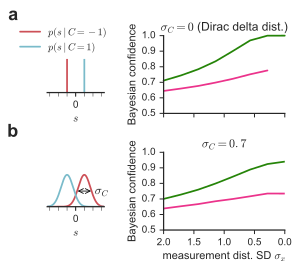

In [8]:
colors=np.array([[235,51,139], [37,132,8]])/255.0 # red, green

mpl.rcParams['xtick.major.pad']='4'
mpl.rcParams['ytick.major.pad']='4'
mpl.rcParams['xtick.major.size']='4'
mpl.rcParams['ytick.major.size']='4'
mpl.rcParams['xtick.minor.size']='4'
mpl.rcParams['ytick.minor.size']='4'
mpl.rcParams['axes.labelpad']='4'

figsize = (3.3,2.7) # W, H
hspace = .15
row_height = .4

cat_plot_w = .24
cat_plot_w_margin = .25
cat_plot_rel_h = .4
cat_plot_h = cat_plot_rel_h*row_height

caption_letter_prop_above = .2
caption_letter_prop_left = 1.2

gs1 = gridspec.GridSpec(2,1)
gs1.update(left=0, right=cat_plot_w, top=1-(row_height-cat_plot_h)/2, bottom=(row_height-cat_plot_h)/2, hspace=2.4)

cats1 = plt.subplot(gs1[0])
cats2 = plt.subplot(gs1[1])

gs2 = gridspec.GridSpec(2, 1)
gs2.update(left=cat_plot_w+cat_plot_w_margin, right=1, top=1, bottom=0, hspace=.5)

g1 = plt.subplot(gs2[0])
g2 = plt.subplot(gs2[1])


# HANDLES ###################
# cats1     g2
# cats2     g2


unif_range = 2
xl = [0,1]
yl = [.5,1]
distxl=[-3.3,3.3]
lo_SD = .25
hi_SD = 1.5
nBins = 80
nTrials = int(1e4) # 2e6
s = np.linspace(distxl[0],distxl[1],500)
markersize=12 # dots on heatmap
#### ROW 1 ##########

# stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='uniform', unif_range=unif_range)
cats1.plot([-1,-1],[0,.6],'-', color=cat1_color, label='$p(s \mid C = -1)$')
cats1.plot([1,1],[0,.6],'-', color=cat2_color, label='$p(s \mid C = 1)$')
cats1.set_xlim(distxl)
cats1.set_ylim([0,.6])
cats1.set_yticks([])
cats1.xaxis.set_major_locator(MultipleLocator(20))
cats1.xaxis.set_minor_locator(MultipleLocator(1))
cats1.set_xticks([0])
cats1.set_xticklabels([0])
cats1.set_xlabel('$s$')
l = cats1.legend(bbox_to_anchor=(1.2, 2.2))
l.axes.set_position(l.axes.get_position())

stimdist_1, stimdist_n1 = sg.stimulus_distributions(type='gaussian', unif_range=unif_range, norm_mean=1, norm_SD=cat_params_g[1])
cats2.plot(s, stimdist_1.pdf(s), '-', color=cat1_color, label='cat. 1')
cats2.plot(s, stimdist_n1.pdf(s), '-', color=cat2_color, label='cat. 2')
cats2.set_xlim(distxl)
cats2.set_ylim([0,.6])
cats2.set_yticks([])
cats2.set_xticklabels('')
cats2.xaxis.set_major_locator(MultipleLocator(20))
cats2.xaxis.set_minor_locator(MultipleLocator(1))
# cats2.tick_params('both', length=4.5, which='minor')
cats2.set_xticks([0])
cats2.set_xticklabels([0])
cats2.set_xlabel('$s$')

cats2.annotate(s='', xy=(0,.28), xytext=(2,.28), arrowprops=dict(arrowstyle='<->', lw=0.8))
cats2.text(2.2, 0.28, '$\sigma_C$', verticalalignment='center')

g1.plot(SDs, correct_conf_g[0], color=colors[1], clip_on=False)
g1.plot(SDs, incorrect_conf_g[0], color=colors[0])
# g1.plot(cat_params_g, accuracy_g[0], 'k-')
g1.set_xlim(np.around([SDs[-1], SDs[0]]))
g1.set_ylim(yl)
g1.set_ylabel('Bayesian confidence')
g1.set_xticklabels('')
# g1.set_xlabel('measurement dist. SD $\sigma_x$')
g1.set_title('$\sigma_C=0$ (Dirac delta dist.)')

caption_letter(g1, 'a', prop_left=caption_letter_prop_left, prop_above=caption_letter_prop_above)


g2.plot(SDs, correct_conf_g[1], color=colors[1])
g2.plot(SDs, incorrect_conf_g[1], color=colors[0])
# g1.plot(cat_params_g, accuracy_g[0], 'k-')
g2.set_xlim(np.around([SDs[-1], SDs[0]]))
g2.set_ylim(yl)
g2.set_ylabel('Bayesian confidence')
g2.set_xlabel('measurement dist. SD $\sigma_x$')
g2.set_title('$\sigma_C=0.7$')

caption_letter(g2, 'b', prop_left=caption_letter_prop_left, prop_above=caption_letter_prop_above)

sns.despine(ax=cats1, left=True)
sns.despine(ax=cats2, left=True)
sns.despine(ax=g1)
sns.despine(ax=g2)


fig = plt.gcf()
fig.set_size_inches(figsize)

# fig.savefig('/Users/will/Google Drive/Will - Confidence/Manuscripts/Signatures/sigs_figs/alt_divergence_tmp.pdf', bbox_inches='tight')

In [83]:
nTrials = 2e6  # 5e5
nSigmas = 16  # 16

SDs = np.linspace(0.001,2,nSigmas)
mu_C = 1

data = [sg.experiment(type='gaussian', nTrials=int(nTrials), meas_SD=meas_SD, norm_mean=mu_C, norm_SD=0) for meas_SD in SDs]

correct_conf = [np.mean(j['conf'][j['correctness']]) for j in data]
incorrect_conf = [np.mean(j['conf'][~j['correctness']]) for j in data]

# accuracy_u = [[np.mean(j['correctness']) for j in i] for i in data_u]
accuracy = [np.mean(j['correctness']) for j in data]

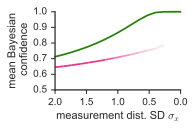

In [223]:
mix_white_at_inaccuracy = .1
white_mix_frac = np.around(np.maximum(0, (1-np.flipud(np.array(accuracy))-mix_white_at_inaccuracy)/.209), decimals=2)

faded_colors = sg.mix_white(np.tile(colors[0], (nSigmas, 1)), white_mix_frac[:, np.newaxis])

xy = np.concatenate((SDs[:, np.newaxis], np.array(incorrect_conf)[:, np.newaxis]), axis=1).reshape(-1,1,2)
segments = np.hstack([xy[:-1], xy[1:]])

collection = LineCollection(segments, color=faded_colors)

fig, ax = plt.subplots(1,1,figsize=(2.25,1.4))
ax.plot(SDs, correct_conf, color=colors[1], clip_on=False)
ax.add_collection(collection)
# ax.plot(SDs, incorrect_conf, color=colors[0])
ax.set_xlim(np.around([max(SDs), min(SDs)], decimals=1))
ax.set_ylim(yl)
ax.set_ylabel('mean Bayesian\n confidence')
ax.set_xlabel('measurement dist. SD $\sigma_x$')
sns.despine(ax=ax)

plt.gcf().savefig('/Users/will/Google Drive/Will - Confidence/Manuscripts/Signatures/sigs_figs/alt_divergence_v3.pdf', bbox_inches='tight')